[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aoguedao/math685_numerical_analysis/blob/main/assigments/hwk03.ipynb)

# MATH685 - Homework #03

_Alonso Ogueda_

## Exercise 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def spline_coefficients(x_knots, y_knots, dy0, dyn):

    # Tridiagonal matrix
    h = np.ediff1d(x_knots)
    mu = np.array([i / (i + j) for i, j in zip(h[:-1], h[1:])])
    lam = 1 - mu
    mu = np.append(mu, 1)
    lam = np.append(1, lam)
    A = 2 * np.identity(len(x_knots)) + np.diagflat(lam, k = 1) + np.diagflat(mu, k = -1)

    # Function values
    d = []
    for i in range(1, len(x_knots) - 1):
        f01 = (y_knots[i] - y_knots[i - 1]) / (x_knots[i] - x_knots[i - 1])
        f12 = (y_knots[i + 1] - y_knots[i]) / (x_knots[i + 1] - x_knots[i])
        f012 = (f12 - f01) / (x_knots[i + 1] - x_knots[i - 1])
        d.append(f012)
    d = 6 * np.array(d)
    d0 = 6 / h[0] * ((y_knots[1] - y_knots[0]) / (x_knots[1] - x_knots[0]) - dy0 )
    dn = 6 / h[-1] * ( dyn - (y_knots[-1] - y_knots[-2]) / (x_knots[-1] - x_knots[-2]) )
    d = np.hstack([d0, d, dn])

    # Coefficients
    z = np.linalg.solve(A, d)
    return z

In [16]:
def spline_interval(x, x1, x2, y1, y2, z1, z2, h):
    x = np.asarray(x)
    s = (
        np.power((x2 - x), 3) * z1 / (6 * h)
        + np.power((x - x1), 3) * z2 / (6 * h)
        + (y1 - (z1 * h ** 2) / 6) * (x2 - x) / h
        + (y2 - (z2 * h ** 2) / 6) * (x - x1) / h
    )
    return s

In [17]:
def spline_values(x_knots, y_knots, dy0, dyn):

    spline_coefs = spline_coefficients(x_knots, y_knots, dy0, dyn)

    x_array = []
    values = []
    h = np.ediff1d(x_knots)
    for i in range(1, len(x_knots)):
        x_array_i = np.linspace(x_knots[i - 1], x_knots[i], 100)
        values_i = spline_interval(
            x=x_array_i,
            x1=x_knots[i - 1],
            x2=x_knots[i],
            y1=y_knots[i - 1],
            y2=y_knots[i],
            z1=spline_coefs[i - 1],
            z2=spline_coefs[i],
            h=h[i-1]
        )
        x_array.append(x_array_i)
        values.append(values_i)
    x_array = np.hstack(x_array)
    values = np.hstack(values)
    return spline_coefs, x_array, values

In [20]:
xa = np.array([1, 2, 5, 6, 7, 8, 10, 13, 17])
ya = np.array([3.0, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5])
dya0 = 1.0
dyan = -0.667

In [21]:
xb = np.array([17, 20, 23, 24, 25, 27, 27.7])
yb = np.array([4.5, 7.0, 6.1, 5.6, 5.8, 5.2, 4.1])
dyb0 = 3.0
dybn = -4.0

In [22]:
xc = np.array([27.7, 28, 29, 30])
yc = np.array([4.1, 4.3, 4.1, 3.0])
dyc0 = 0.33
dycn = -1.5

In [23]:
coefs_a, x_array_a, values_a = spline_values(xa, ya, dya0, dyan)
coefs_b, x_array_b, values_b = spline_values(xb, yb, dyb0, dybn)
coefs_c, x_array_c, values_c = spline_values(xc, yc, dyc0, dycn)

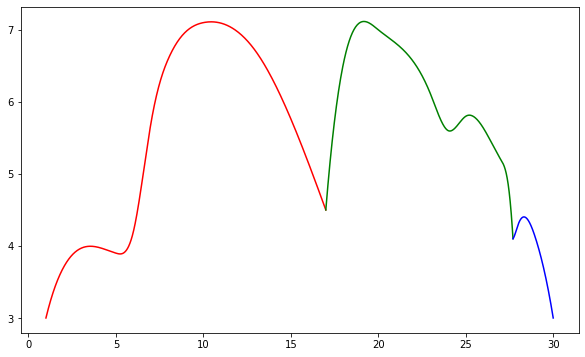

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_array_a, values_a, color="red")
ax.plot(x_array_b, values_b, color="green")
ax.plot(x_array_c, values_c, color="blue")
fig.show()

## Question 7

In [45]:
import pandas as pd

In [52]:
x_knots = np.array([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
y_knots = np.array([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
data = pd.DataFrame(
    [
        [-0.1353, -0.1540, -0.0707, 0.0707, 0.1540, 0.1353],
        [-0.2567, -0.2921, -0.1341, 0.1341, 0.2921, 0.2567],
        [-0.3535, -0.4022, -0.1846, 0.1846, 0.4022, 0.3535],
        [-0.3535, -0.4022, -0.1846, 0.1846, 0.4022, 0.3535],
        [-0.2567, -0.2921, -0.1341, 0.1341, 0.2921, 0.2567],
        [-0.1353, -0.1540, -0.0707, 0.0707, 0.1540, 0.1353]
    ],
    index=y_knots,
    columns=x_knots
)
data

,-1.0,-0.6,-0.2,0.2,0.6,1.0
-1.0,-0.1353,-0.1540,-0.0707,0.0707,0.1540,0.1353
-0.6,-0.2567,-0.2921,-0.1341,0.1341,0.2921,0.2567
-0.2,-0.3535,-0.4022,-0.1846,0.1846,0.4022,0.3535
0.2,-0.3535,-0.4022,-0.1846,0.1846,0.4022,0.3535
0.6,-0.2567,-0.2921,-0.1341,0.1341,0.2921,0.2567
1.0,-0.1353,-0.1540,-0.0707,0.0707,0.1540,0.1353


In [53]:
x = 0.1
y = -0.7

In [54]:
x1 = x_knots[x >= x_knots].max()
x2 = x_knots[x <= x_knots].min()
y1 = y_knots[y >= y_knots].max()
y2 = y_knots[y <= y_knots].min()

In [59]:
print(x1, x2)
print(y1, y2)

-0.2 0.2
-1.0 -0.6


In [65]:
q11 = data.loc[y1, x1]
q12 = data.loc[y2, x1]
q21 = data.loc[y1, x2]
q22 = data.loc[y2, x2]
Q = np.array([[q11, q12], [q21, q22]])

In [69]:
fxy = (
    np.array([x2 - x, x - x1], ndmin=2)
    @
    Q
    @ np.array([y2 - y, y - y1], ndmin=2).T
    / (x2 - x1)
    / (y2 - y1)
).item()
fxy

0.05912500000000002